TensorFlow version: 2.16.1
Keras version: 3.3.3
Thu Jun  6 00:22:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX250         WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   58C    P0              N/A / ERR! |      0MiB /  4096MiB |      2%      Default |
|                                         |                      |                  N/A |
+-------------------

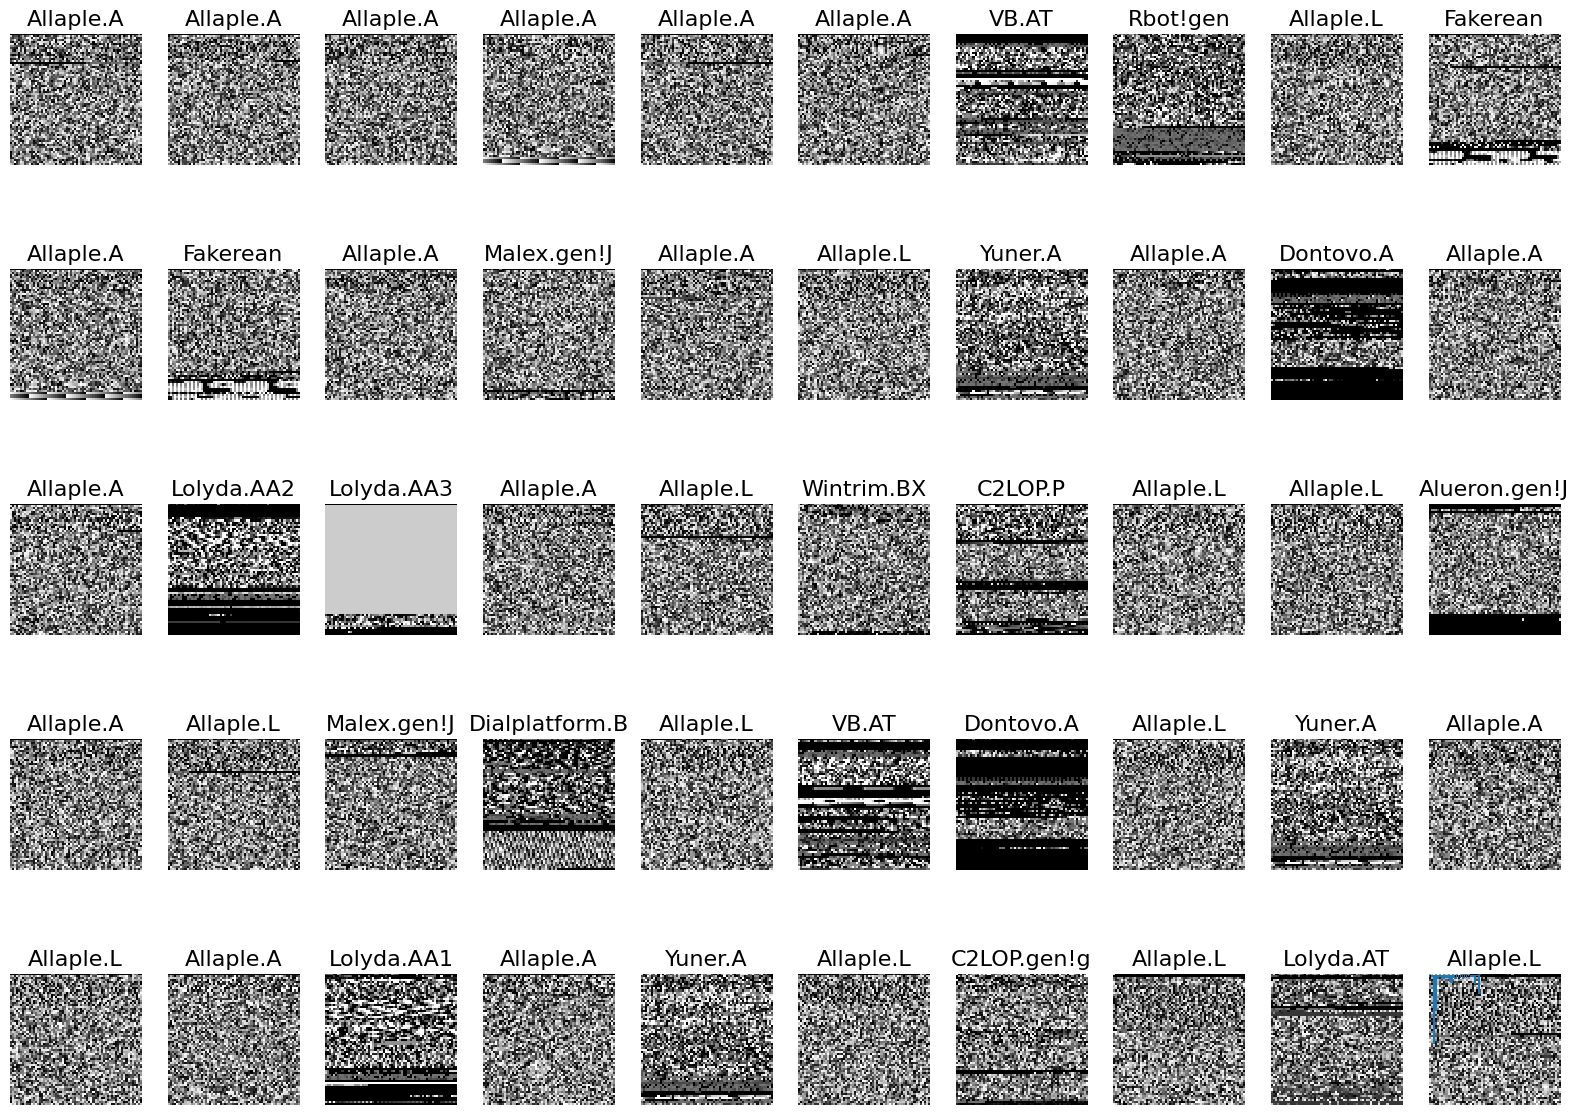

x_train shape: (5882, 64, 64, 3) - y_train shape: (5882, 25)
x_test shape: (2522, 64, 64, 3) - y_test shape: (2522, 25)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.3032 - f1_score: 0.0934 - iou: 0.1008 - loss: 2.5955 - sensitivity: 0.0742 - specificity: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.55735, saving model to best_nest_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.3038 - f1_score: 0.0945 - iou: 0.1013 - loss: 2.5918 - sensitivity: 0.0751 - specificity: 0.9963 - val_accuracy: 0.5573 - val_f1_score: 0.5725 - val_iou: 0.3162 - val_loss: 1.1996 - val_sensitivity: 0.4874 - val_specificity: 0.9911 - learning_rate: 0.0010
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6998 - f1_score: 0.6990 - iou: 0.4423 - loss: 0.9647 - sensitivity: 0.6204 - specificity: 0.9944
Epoch 2: val_accuracy improved from 0.55735 to 0.89210, saving model to best_nest_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0

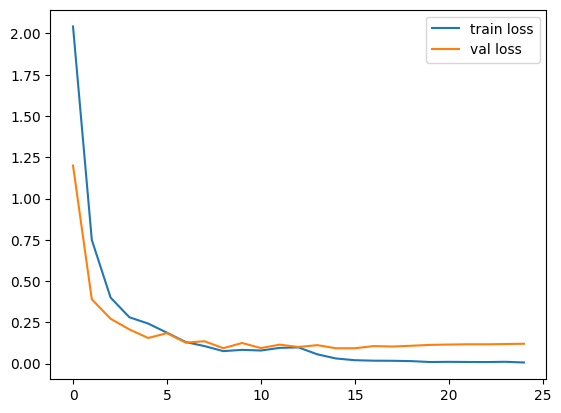

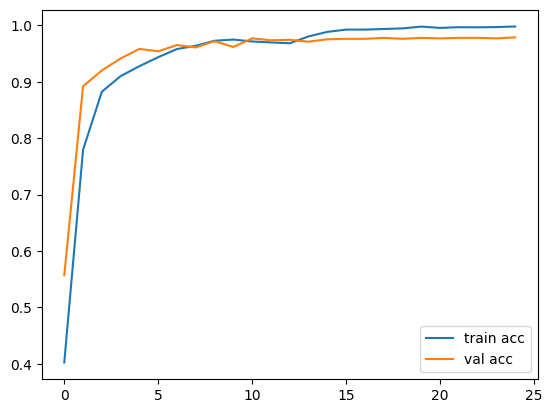

Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 432ms/step - accuracy: 0.9814 - f1_score: 0.9824 - iou: 0.9611 - loss: 0.0549 - sensitivity: 0.9805 - specificity: 0.9993
Test Loss: 0.06555251777172089, Test Accuracy: 0.9825535416603088
Training Accuracy: 0.9980871677398682, Validation Accuracy: 0.9787595868110657
Training Loss: 0.006561207585036755, Validation Loss: 0.12007930874824524
Confusion matrix image saved at confusion_matrix_nest.png
              precision    recall  f1-score   support

           0      0.958     1.000     0.979        23
           1      1.000     1.000     1.000        26
           2      1.000     1.000     1.000       876
           3      0.998     0.998     0.998       431
           4      0.982     1.000     0.991        54
           5      1.000     1.000     1.000        26
           6      0.800     0.848     0.824        33
           7      0.870     0.889     0.879        45
           8      1.000     0.980     0.990        49
       

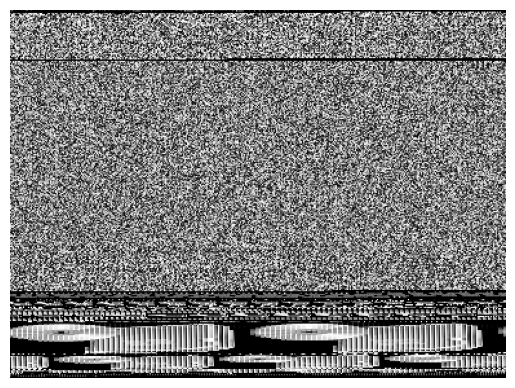

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
The predicted class for the input image is: Fakerean


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import backend as K
import json

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# GPU Check
!nvidia-smi

# Custom metrics
def iou(y_true, y_pred, smooth=0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Display Confusion Matrix as Image
def display_confusion_matrix_as_image(y_true, y_pred, class_names, save_path):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.savefig(save_path)
    plt.close()
    print(f"Confusion matrix image saved at {save_path}")

# Prepare the data
train_root_path = r"E:\MalImg dataset\dataset_9010\dataset_9010\malimg_dataset\train"
val_root_path = r"E:\MalImg dataset\dataset_9010\dataset_9010\malimg_dataset\validation"

batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(64, 64), batch_size=10000)
imgs, labels = next(batches)
print(imgs.shape, labels.shape)

# Function to plot images with labels
def plots(ims, figsize=(20, 30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    cols = 10
    for i in range(0, 50):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=labels)

# Calculate class distribution
classes = list(batches.class_indices.keys())
perc = (sum(labels) / labels.shape[0]) * 100
plt.xticks(rotation='vertical')
plt.bar(classes, perc)
plt.show()

# Split the data
x_train, x_test, y_train, y_test = train_test_split(imgs / 255.0, labels, test_size=0.3)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

num_classes = len(classes)

class NesTBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1):
        super(NesTBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size, strides, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(filters, kernel_size, strides, padding="same", activation="relu")
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.pool(x)

def create_nest_classifier(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = NesTBlock(64)(inputs)
    x = NesTBlock(128)(x)
    x = NesTBlock(256)(x)
    x = NesTBlock(512)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(2048, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

# Model parameters
input_shape = (64, 64, 3)
num_classes = len(classes)
learning_rate = 1e-3

nest_classifier = create_nest_classifier(input_shape=input_shape, num_classes=num_classes)

nest_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", f1_score, specificity, sensitivity, iou]
)

# Callbacks
checkpoint = ModelCheckpoint("best_nest_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
csv_logger = CSVLogger('NesT_Model.log')
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Train the Model
history = nest_classifier.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)
nest_classifier.save("nest_model.keras")
print("Saved model to disk")

# Plot training & validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Evaluate the Model and Print Results
print("Evaluate on test data")
results = nest_classifier.evaluate(x_test, y_test, batch_size=32)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

# Print training accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

# Print loss and accuracy
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")

# Make Predictions and Save Model to JSON
pred_x = nest_classifier.predict(x_test, verbose=0)
y_pred = np.argmax(pred_x, axis=1)
y_test2 = np.argmax(y_test, axis=1)

# Display Confusion Matrix as Image
display_confusion_matrix_as_image(y_test2, y_pred, classes, 'confusion_matrix_nest.png')

# Classification Report
report = classification_report(y_test2, y_pred, digits=3, output_dict=True)
df = pd.DataFrame(report).transpose().reset_index().rename(columns={"index": "class_label"})

# Review classification report
clf_rep = classification_report(y_test2, y_pred, digits=3)
print(clf_rep)

# Display aggregated values
options = ['accuracy', 'macro avg', 'weighted avg']
agg_df = df[df['class_label'].isin(options)]
print(agg_df)

# Save the model to JSON
model_json = nest_classifier.to_json()
with open("nest_model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to JSON")

# Predict and Show Output for New Input Image
def prepare_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(model, img_array, class_names):
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)
    return class_names[pred_class[0]]

# User input image path
img_path = r"E:\F boliom\Downloads\00a6163bad908d7f396e3c13a989bfd4.png"  # Replace with the path to the image
img_array = prepare_image(img_path, (64, 64))

# Show the image
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict and display the result
predicted_class = predict_image(nest_classifier, img_array, classes)
print(f"The predicted class for the input image is: {predicted_class}")
